<a href="https://colab.research.google.com/github/LucasHLirio/TCC_II/blob/main/BO_MNIST_keras_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras

Install and import the Keras Tuner.

In [2]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.4 MB/s eta 0:00:00


In [3]:
import keras_tuner as kt

## Download and prepare the dataset

First, load the data and normalize the pixels values from the images:

In [4]:
# (img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()
(img_train, label_train), (img_test, label_test) = keras.datasets.mnist.load_data(path="mnist.npz")

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

from keras.utils import to_categorical
# One-hot encode labels.
label_train = to_categorical(label_train, num_classes=10)
label_test = to_categorical(label_test, num_classes=10)

## Define the model


In [6]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer with values between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

## Instantiate the tuner and perform hypertuning


In [7]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_accuracy',
    num_initial_points=50,
    max_trials=15,
    directory='my_dir',
    project_name='cnn_bayes')

Create a callback to stop training early after reaching a certain value for the validation loss.

In [8]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Run the hyperparameter search. The arguments for the search method are the same as those used for `tf.keras.model.fit` in addition to the callback above.

In [9]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 15 Complete [00h 01m 03s]
val_accuracy: 0.9758333563804626

Best val_accuracy So Far: 0.9790833592414856
Total elapsed time: 00h 16m 26s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 256 and the optimal learning rate for the optimizer
is 0.001.



## Train the model

In [10]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(img_train, label_train, epochs=50, validation_split=0.4)

Epoch 1/50
1125/1125 [==============================] - 6s 5ms/step - loss: 0.2807 - accuracy: 0.9187 - val_loss: 0.1641 - val_accuracy: 0.9528
Epoch 2/50
1125/1125 [==============================] - 5s 4ms/step - loss: 0.1178 - accuracy: 0.9643 - val_loss: 0.1296 - val_accuracy: 0.9617
Epoch 3/50
1125/1125 [==============================] - 5s 5ms/step - loss: 0.0768 - accuracy: 0.9766 - val_loss: 0.1078 - val_accuracy: 0.9688
Epoch 4/50
1125/1125 [==============================] - 6s 5ms/step - loss: 0.0540 - accuracy: 0.9835 - val_loss: 0.1009 - val_accuracy: 0.9697
Epoch 5/50
1125/1125 [==============================] - 5s 5ms/step - loss: 0.0390 - accuracy: 0.9879 - val_loss: 0.1053 - val_accuracy: 0.9692
Epoch 6/50
1125/1125 [==============================] - 6s 5ms/step - loss: 0.0265 - accuracy: 0.9922 - val_loss: 0.1050 - val_accuracy: 0.9697
Epoch 7/50
1125/1125 [==============================] - 6s 6ms/step - loss: 0.0208 - accuracy: 0.9936 - val_loss: 0.1090 - val_accuracy:

To finish this tutorial, evaluate the hypermodel on the test data.

In [11]:
eval_result = hypermodel.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 2s 5ms/step - loss: 0.1471 - accuracy: 0.9787
[test loss, test accuracy]: [0.14709778130054474, 0.9786999821662903]


Text(0.5, 1.0, 'Loss Curves')

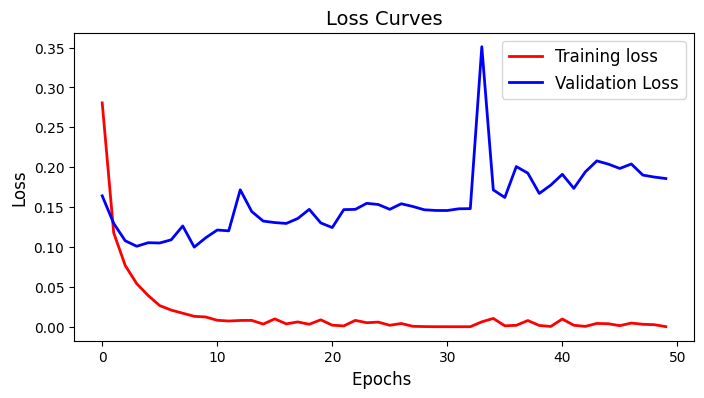

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=[8,4])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves',fontsize=14)

Text(0.5, 1.0, 'Accuracy Curves')

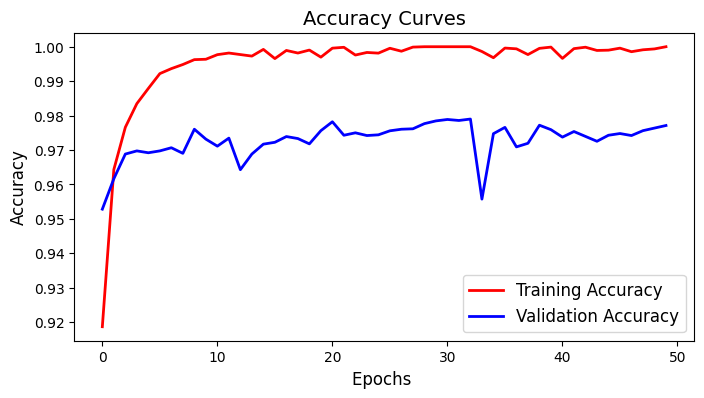

In [13]:
plt.figure(figsize=[8,4])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Accuracy Curves',fontsize=14)